In [3]:
import sys
sys.path.append('../../')

from tqdm import tqdm

import torch as tc
import numpy as np
import matplotlib.pyplot as plt

from rcgp.rcgp import SpatioTemporalRCGP

from data.simulations import spatio_temporal_half_contaminated

In [4]:
def plot(idx, grid, ts, pred, Ys, Ys_no_outliers, outliers_loc, true_Ys, n_lon, n_lat):

    x,y = grid[:, 0], grid[:, 1]
    X = x.reshape(n_lon, n_lat)
    Y = y.reshape(n_lon, n_lat)
    
    pred = pred[idx].reshape(n_lon, n_lat)
    Ys = Ys[idx].reshape(n_lon, n_lat)
    Ys_no_outliers = Ys_no_outliers[idx].reshape(n_lon, n_lat)
    true_Ys = true_Ys[idx].reshape(n_lon, n_lat)


    fig, axs = plt.subplots(1, 3, figsize=(12,3))
    kwargs = {"levels" : 20, "cmap": "YlGnBu", "vmin" : Ys_no_outliers.min().item(), "vmax" : Ys_no_outliers.max().item()}

    outliers_loc_t = outliers_loc[np.where(np.isclose(outliers_loc[:, 0], ts[idx]))]

    axs[0].contourf(X, Y, pred, **kwargs)
    axs[1].contourf(X, Y, Ys_no_outliers, **kwargs)
    axs[1].scatter(outliers_loc_t[:, 1], outliers_loc_t[:, 2], marker='.', s=30., color='red')
    axs[2].contourf(X, Y, true_Ys, **kwargs)
    
    axs[0].set_title("Prediction")
    axs[1].set_title("Data")
    axs[2].set_title("True Latent Function")

    print("Mean Absolute Difference (Data - No Outliers) : ", np.abs(Ys_no_outliers - true_Ys).sum().item())
    print("Mean Absolute Difference (Prediction) : ", np.abs(pred - true_Ys).sum().item())

    return

In [5]:
ts, grids, Ys, true_Ys, Ys_no_outliers, outliers_loc, n_lon, n_lat, lon_norm, lat_norm = spatio_temporal_half_contaminated()

In [6]:
def scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor):

    S = covs + R
    eps = Ys - preds

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)
    
    return energies.sum()

## Experiment : Comparing STGP vs Robust RCGP When Training on Absolute Diff Loss With Known True Function

### STGP

100%|██████████| 25/25 [00:54<00:00,  2.18s/it]


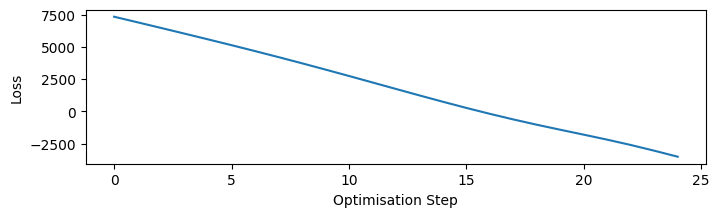

In [7]:
gp = SpatioTemporalRCGP(ts=ts, grid=grids[0], Ys=Ys, p=1)
gp.deactivate_robustness() #STGP

losses = []
n_steps = 25
lr = 0.2

optimizer = tc.optim.Adam(gp.parameters(), lr=lr)

for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = gp.forward(smoothing=False)

    loss = scoring_rule(Ys=true_Ys, preds=preds, covs=covs, R=R)
    loss.backward()
    losses.append(loss.clone().detach())
    
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [8]:
print("---Likelihood Variance----")
print(gp.var_y.clone().detach().item())
print("\n----Spatial Lengthscale, Magnitude-----")
print(gp.spatial_lengthscale.clone().detach().item(), gp.spatial_magnitude.clone().detach().item())
print("\n----Temporal Lengthscale, Magnitude----")
print(gp.temporal_lengthscale.clone().detach().item(), gp.temporal_magnitude.clone().detach().item())

---Likelihood Variance----
0.019419420510530472

----Spatial Lengthscale, Magnitude-----
6.26257848739624 1.0305304527282715

----Temporal Lengthscale, Magnitude----
0.13157512247562408 1.0294026136398315


Sum of Absolute Diff (pred - true) :  tensor(921.6194) 

Mean Absolute Difference (Data - No Outliers) :  101.3565444946289
Mean Absolute Difference (Prediction) :  74.74720764160156
Mean Absolute Difference (Data - No Outliers) :  97.08243560791016
Mean Absolute Difference (Prediction) :  82.44969940185547
Mean Absolute Difference (Data - No Outliers) :  98.51832580566406
Mean Absolute Difference (Prediction) :  121.22355651855469
Mean Absolute Difference (Data - No Outliers) :  100.95301818847656
Mean Absolute Difference (Prediction) :  92.17894744873047
Mean Absolute Difference (Data - No Outliers) :  93.23451232910156
Mean Absolute Difference (Prediction) :  92.85867309570312
Mean Absolute Difference (Data - No Outliers) :  97.20365142822266
Mean Absolute Difference (Prediction) :  92.99132537841797
Mean Absolute Difference (Data - No Outliers) :  100.76924896240234
Mean Absolute Difference (Prediction) :  96.47147369384766
Mean Absolute Difference (Data - No Outliers) :  98.465545

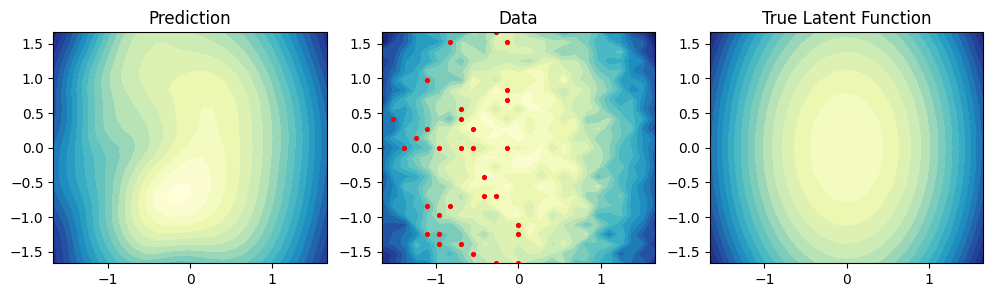

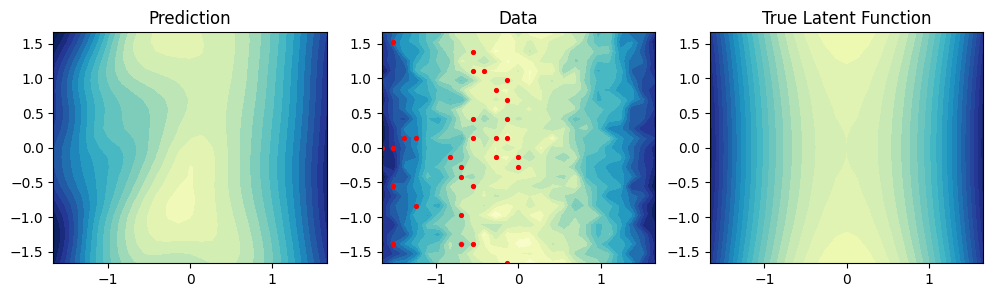

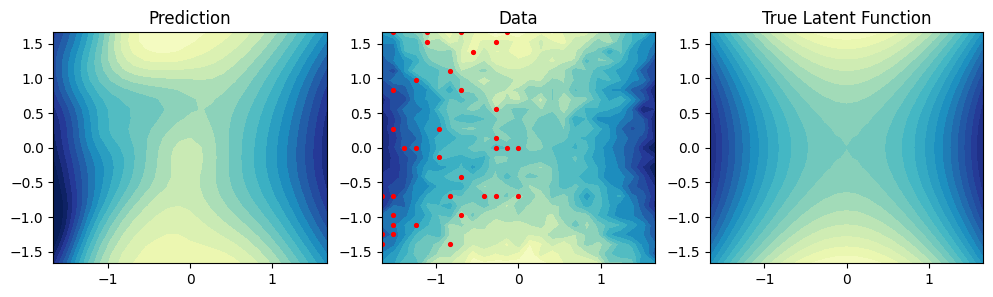

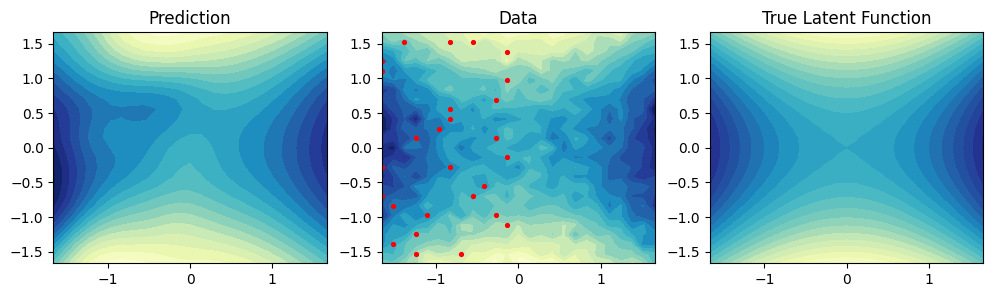

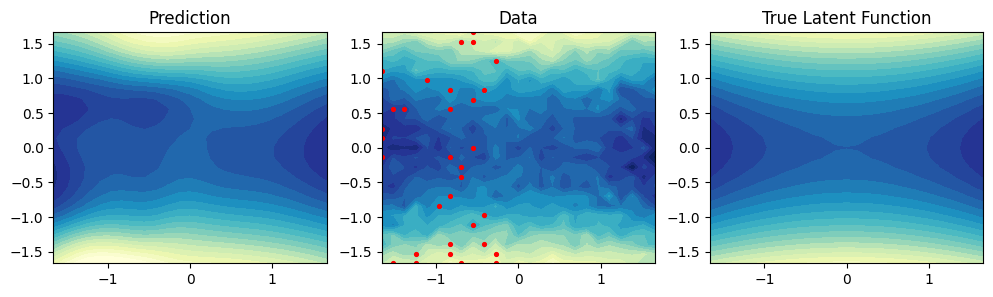

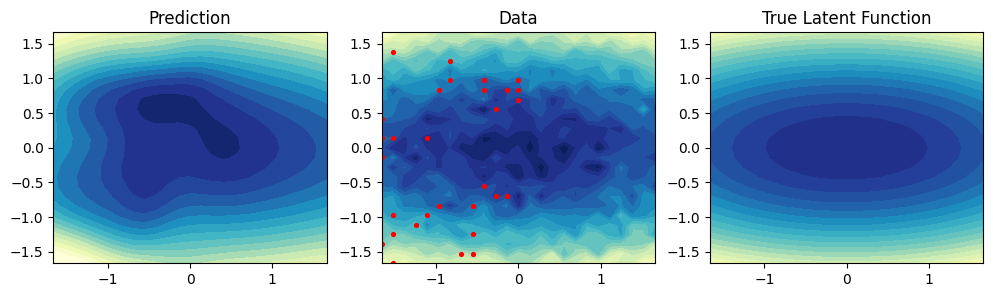

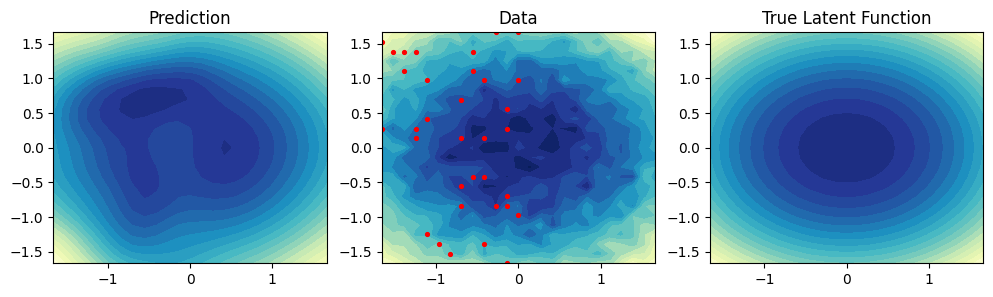

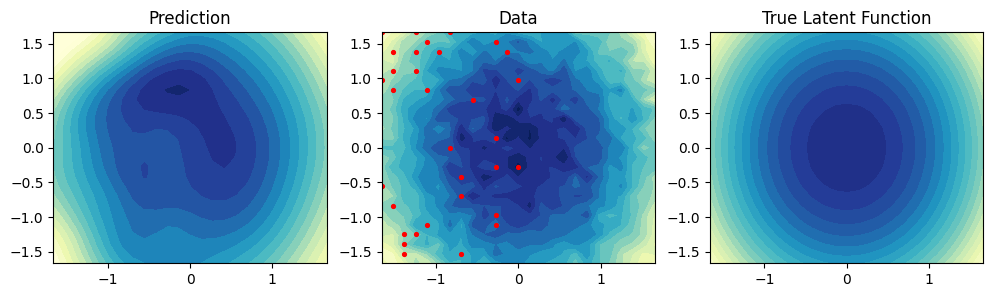

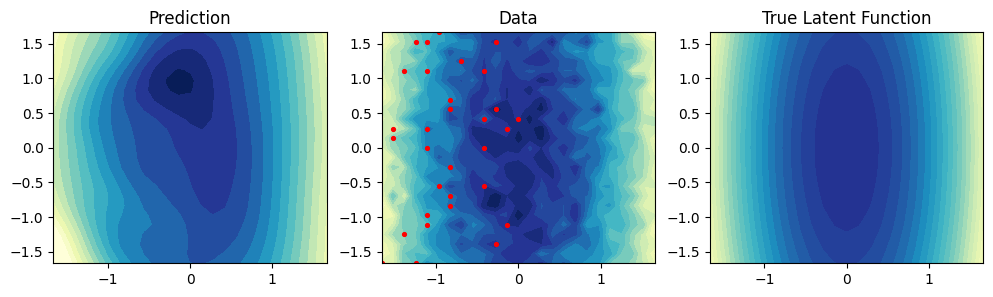

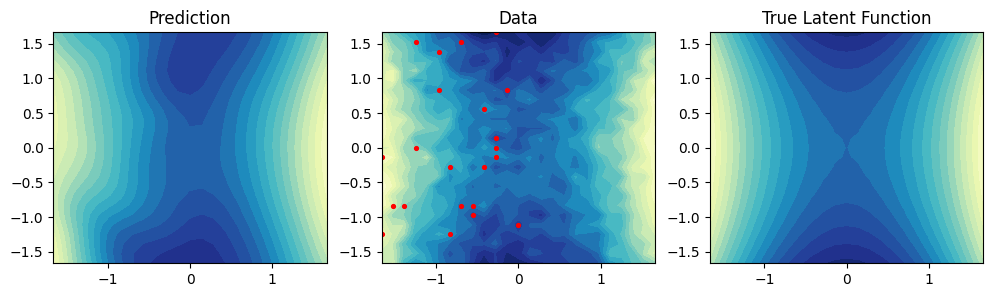

In [9]:
with tc.no_grad():
    (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = gp.forward(smoothing=True)

    print("Sum of Absolute Diff (pred - true) : ", (tc.abs(preds_smooth - true_Ys.squeeze(-1))).sum(), "\n")

for i in range(10):
    plot(idx=i, grid=grids[0], ts=ts, pred=preds_smooth, Ys=Ys, Ys_no_outliers=Ys_no_outliers, outliers_loc=outliers_loc, true_Ys=true_Ys, n_lon=n_lon, n_lat=n_lat)

### ST-RCGP (adaptive c, spatial smoothing prior mean)

If the optim runs for longer, the results explode. This loss is not adequate for our model.

100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


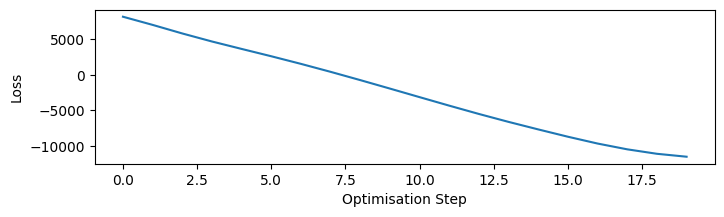

In [10]:
gp = SpatioTemporalRCGP(ts=ts, grid=grids[0], Ys=Ys, p=1)

gp.activate_robustness(func="local_constant") 
gp._K_w_lengthscale = 1.

gp.c=1

losses = []
n_steps = 20
lr = 0.4

optimizer = tc.optim.Adam(gp.parameters(), lr=lr)

for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = gp.forward(smoothing=False)

    loss = scoring_rule(Ys=true_Ys, preds=preds, covs=covs, R=R)
    loss.backward()
    losses.append(loss.clone().detach())

    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [11]:
print("---Likelihood Variance----")
print(gp.var_y.clone().detach().item())
print("\n----Spatial Lengthscale, Magnitude-----")
print(gp.spatial_lengthscale.clone().detach().item(), gp.spatial_magnitude.clone().detach().item())
print("\n----Temporal Lengthscale, Magnitude----")
print(gp.temporal_lengthscale.clone().detach().item(), gp.temporal_magnitude.clone().detach().item())

---Likelihood Variance----
0.0009240671643055975

----Spatial Lengthscale, Magnitude-----
7.209110736846924 1.7284849882125854

----Temporal Lengthscale, Magnitude----
0.32676324248313904 1.7263792753219604


Sum Absolute Diff (pred - true) :  tensor(2259.9333) 

Mean Absolute Difference (Data - No Outliers) :  101.3565444946289
Mean Absolute Difference (Prediction) :  193.171630859375
Mean Absolute Difference (Data - No Outliers) :  97.08243560791016
Mean Absolute Difference (Prediction) :  69.17147827148438
Mean Absolute Difference (Data - No Outliers) :  98.51832580566406
Mean Absolute Difference (Prediction) :  24.595327377319336
Mean Absolute Difference (Data - No Outliers) :  100.95301818847656
Mean Absolute Difference (Prediction) :  23.053730010986328
Mean Absolute Difference (Data - No Outliers) :  93.23451232910156
Mean Absolute Difference (Prediction) :  27.25583267211914
Mean Absolute Difference (Data - No Outliers) :  97.20365142822266
Mean Absolute Difference (Prediction) :  28.056209564208984
Mean Absolute Difference (Data - No Outliers) :  100.76924896240234
Mean Absolute Difference (Prediction) :  30.544544219970703
Mean Absolute Difference (Data - No Outliers) :  98.465545

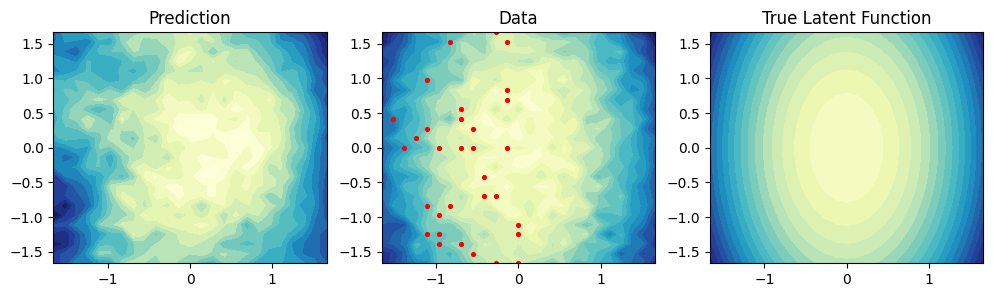

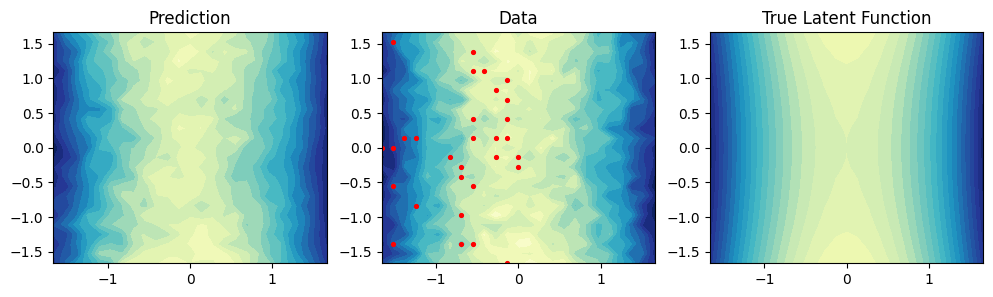

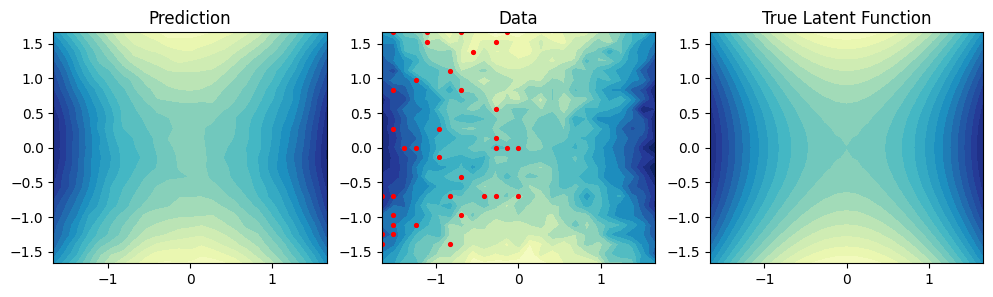

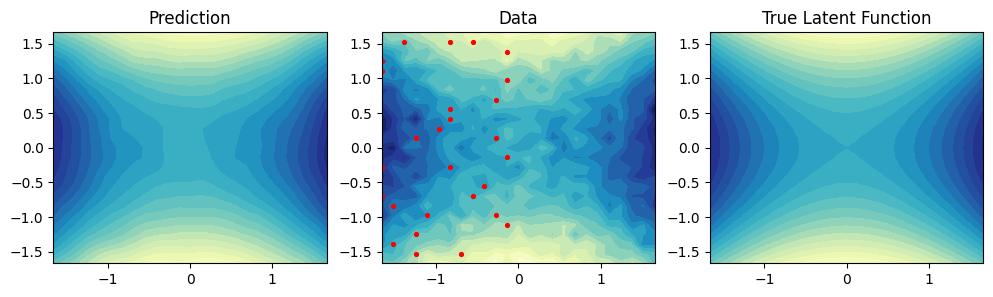

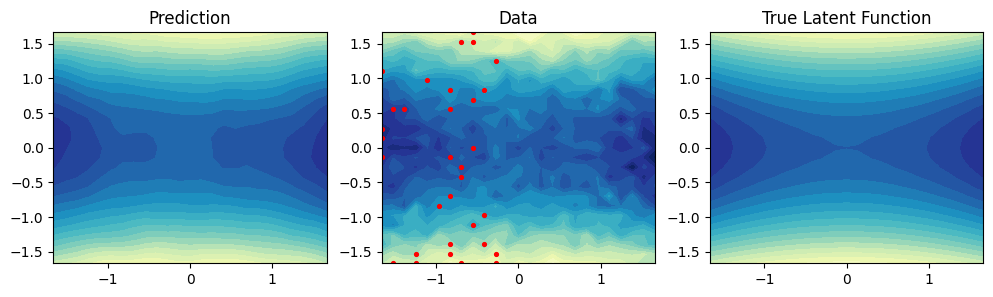

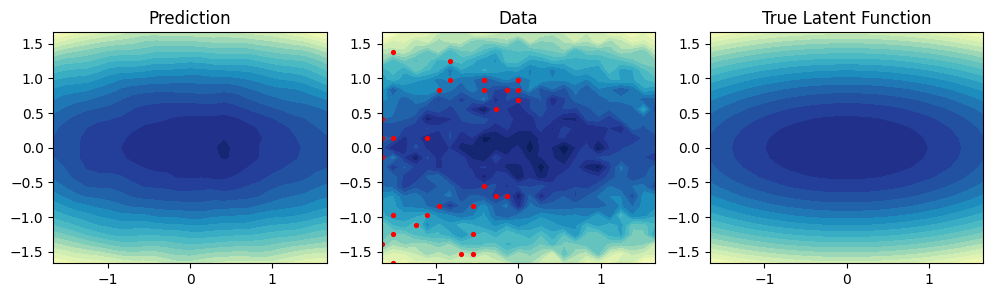

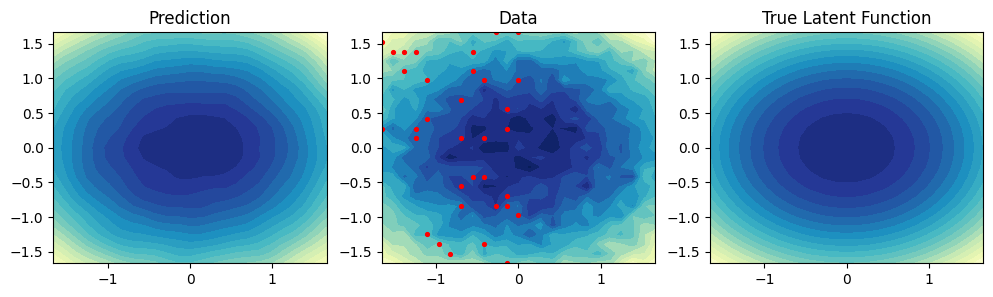

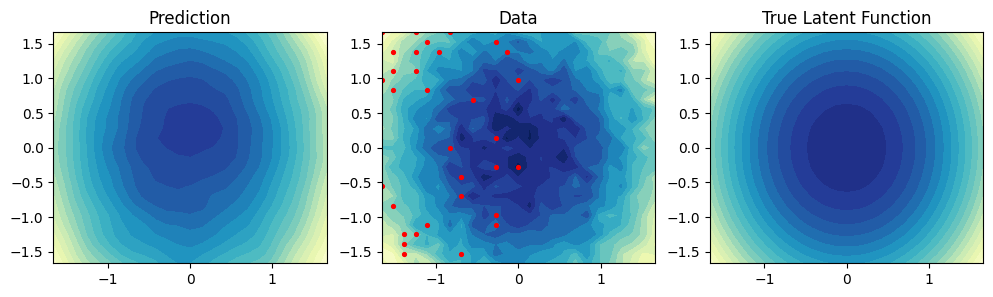

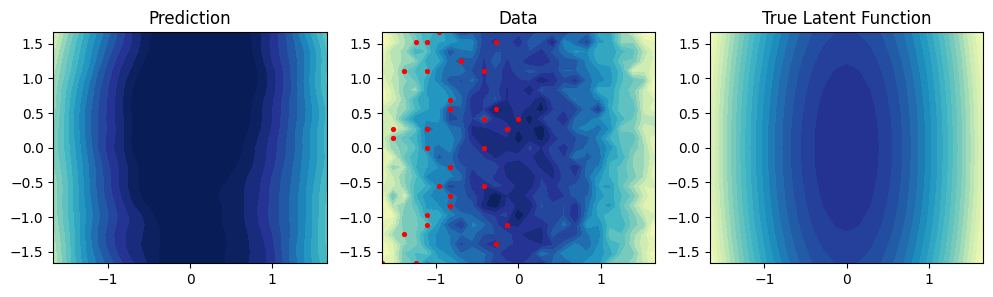

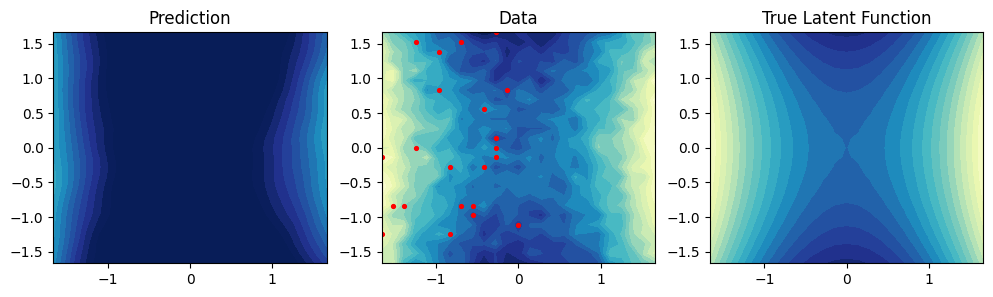

In [12]:
with tc.no_grad():
    (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = gp.forward(smoothing=True)

    print("Sum Absolute Diff (pred - true) : ", (tc.abs(preds_smooth - true_Ys.squeeze(-1))).sum(), "\n")

for i in range(10):
    plot(idx=i, grid=grids[0], ts=ts, pred=preds_smooth, Ys=Ys, Ys_no_outliers=Ys_no_outliers, outliers_loc=outliers_loc, true_Ys=true_Ys, n_lon=n_lon, n_lat=n_lat)